<a href="https://colab.research.google.com/github/spavliga/64061_spavliga/blob/main/Assignment%203%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-03-25 14:28:04--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.24.247, 16.182.64.56, 16.182.39.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.24.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  45.9MB/s    in 0.3s    

2025-03-25 14:28:05 (45.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

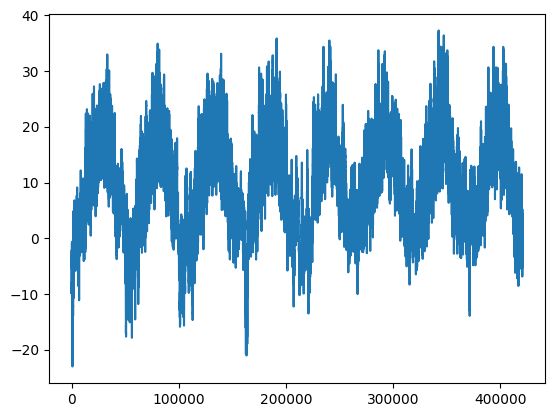

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

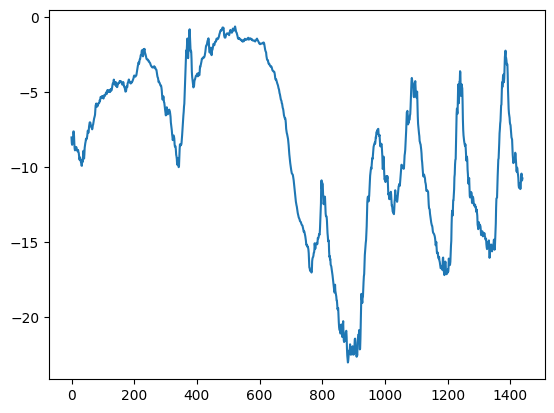

In [ ]:
plt.plot(range(1440), temperature[:1440])

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
from tensorflow import keras

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
 # print("flattened shape:", samples.numpy().reshape(samples.shape[0], -1).shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
  keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 58ms/step - loss: 19.4400 - mae: 3.3099 - val_loss: 10.1361 - val_mae: 2.5175
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 9.0610 - mae: 2.3724 - val_loss: 13.2577 - val_mae: 2.8949
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - loss: 8.4005 - mae: 2.2868 - val_loss: 10.2818 - val_mae: 2.5314
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 7.9197 - mae: 2.2226 - val_loss: 10.1840 - val_mae: 2.5219
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 56ms/step - loss: 7.6050 - mae: 2.1784 - val_loss: 11.1502 - val_mae: 2.6548
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 58ms/step - loss: 7.3589 - mae: 2.1405 - val_loss: 10.5210 - val_mae: 2.5663
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 7.1514 - mae: 2.1142 - val_loss: 10.3445 - val_mae: 2.5414
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 6.9832 - mae: 2.0864 - val_loss: 13.0449 - val_mae: 2.8678
Epoch 9/10
819/819 ━━━━━━━━━━━━

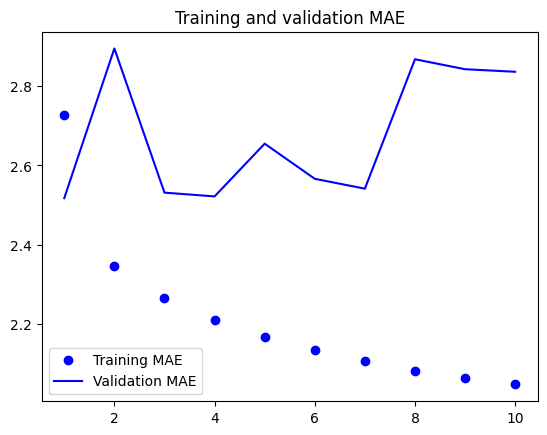

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Using LSTM model-

In [ ]:
from keras import layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                  save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - loss: 63.8740 - mae: 6.0690 - val_loss: 11.7356 - val_mae: 2.6238
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 11.6580 - mae: 2.6467 - val_loss: 9.4094 - val_mae: 2.3746
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - loss: 9.8821 - mae: 2.4497 - val_loss: 9.2809 - val_mae: 2.3686
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - loss: 9.2928 - mae: 2.3776 - val_loss: 9.1792 - val_mae: 2.3523
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 8.8094 - mae: 2.3163 - val_loss: 9.3667 - val_mae: 2.3766
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 8.4443 - mae: 2.2661 - val_loss: 9.7821 - val_mae: 2.4334
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 8.1889 - mae: 2.2303 - val_loss: 9.5920 - val_mae: 2.4011
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 52ms/step - loss: 7.9974 - mae: 2.2033 - val_loss: 9.5950 - val_mae: 2.3946
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

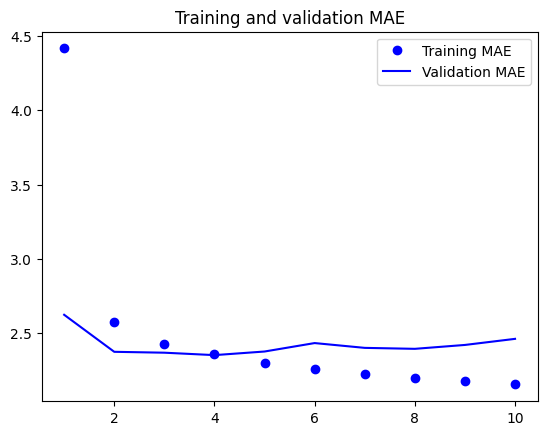

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

dropout regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=50,
            validation_data=val_dataset,
            callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 147s 176ms/step - loss: 47.6662 - mae: 5.1178 - val_loss: 9.5209 - val_mae: 2.3992
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 176ms/step - loss: 15.0446 - mae: 3.0180 - val_loss: 9.0641 - val_mae: 2.3394
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 148s 180ms/step - loss: 14.2867 - mae: 2.9335 - val_loss: 9.0375 - val_mae: 2.3363
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 176ms/step - loss: 13.7506 - mae: 2.8811 - val_loss: 9.0899 - val_mae: 2.3353
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - loss: 13.2447 - mae: 2.8323 - val_loss: 9.2452 - val_mae: 2.3505
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 172ms/step - loss: 12.9803 - mae: 2.7970 - val_loss: 9.0722 - val_mae: 2.3288
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 161s 196ms/step - loss: 12.7360 - mae: 2.7709 - val_loss: 8.8913 - val_mae: 2.3031
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - loss: 12.5047 - mae: 2.7436 - val_loss: 8.8997 - val_mae: 2.3053
Epoch 9/50
819/8

In [ ]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - loss: 9.8882 - mae: 2.4825
Test MAE: 2.49


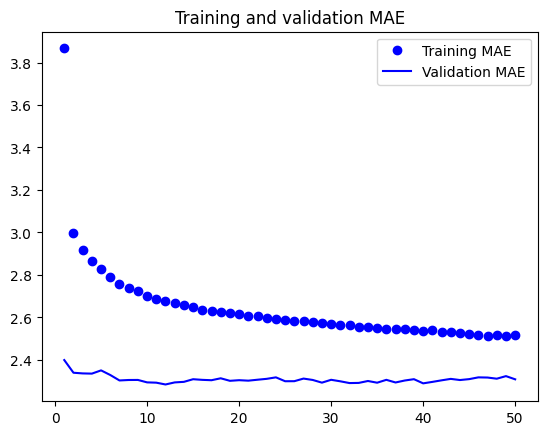

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Stacked GRU model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
  keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                  save_best_only=True)
  ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=50,
            validation_data=val_dataset,
            callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 284s 338ms/step - loss: 44.7079 - mae: 4.9166 - val_loss: 9.2556 - val_mae: 2.3524
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 319s 389ms/step - loss: 14.4578 - mae: 2.9502 - val_loss: 8.6528 - val_mae: 2.2819
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 279s 340ms/step - loss: 13.6652 - mae: 2.8617 - val_loss: 9.0803 - val_mae: 2.3411
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 283s 345ms/step - loss: 13.0788 - mae: 2.8048 - val_loss: 8.5351 - val_mae: 2.2626
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 321s 345ms/step - loss: 12.7233 - mae: 2.7682 - val_loss: 8.6231 - val_mae: 2.2805
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 319s 341ms/step - loss: 12.3330 - mae: 2.7274 - val_loss: 8.3622 - val_mae: 2.2370
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 321s 340ms/step - loss: 11.9738 - mae: 2.6872 - val_loss: 8.2866 - val_mae: 2.2290
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 313s 382ms/step - loss: 11.6281 - mae: 2.6472 - val_loss: 8.4065 - val_mae: 2.2493
Epoch 9/50
819/8

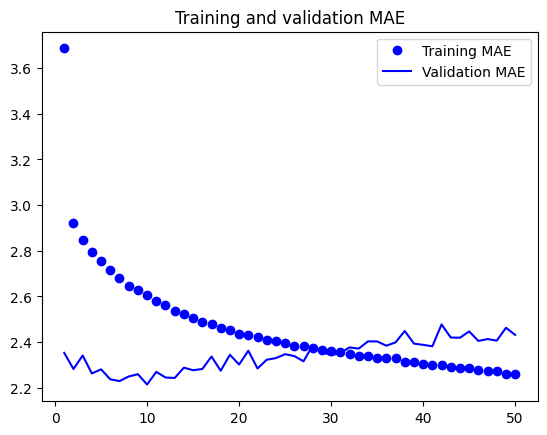

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Does result in a better model